<a href="https://colab.research.google.com/github/angelinasinaga/Indonesian_Named-entity_Recognition/blob/main/Pasupasu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. LOAD DATA** ##

**1.1 Import Libraries**

In [1]:
#Data analysis   
import pandas as pd 
import numpy as np
import csv
import nltk
import tensorflow as tf

In [2]:
#Data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
from matplotlib import ticker
%config InlineBackend.figure_format = 'svg'

In [3]:
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.4 MB/s 


In [5]:
# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

**1.2 Load Data**

In [6]:
\from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
list_kalimat = []
nomor_kalimat = 1

# open file in read mode
with open('/content/drive/MyDrive/pba/dataset/singgalang.tsv', encoding='UTF-8') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj, delimiter='\t', quotechar=None)
# Menginstruksikan reader untuk tidak melakukan pemrosesan khusus terhadap karakter kutipan
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        if len(row) == 0:
            nomor_kalimat += 1 
        else:
            tmp_row= row
            tmp_row.append(nomor_kalimat)
            list_kalimat.append(tmp_row)

dataset = pd.DataFrame(list_kalimat, columns=['token', 'entitas bernama', 'kalimat'])

In [8]:
dataset.head()

,token,entitas bernama,kalimat
0,Ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,Presiden,O,1
4,ketiga,O,1


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478268 entries, 0 to 1478267
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   token            1478268 non-null  object
 1   entitas bernama  1478268 non-null  object
 2   kalimat          1478268 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 33.8+ MB


## **2. Exploring / Visualisasi Data (Analisis Data)** ##

Membangun kelas sederhana untuk menggabungkan kata-kata ke dalam kalimat. 

In [10]:
print("Jumlah kalimat: ", len(dataset.groupby(['kalimat'])))
words = list(set(dataset["token"].values))
n_words = len(words)
print("Jumlah kata unik : ", n_words)
tags = list(set(dataset["entitas bernama"].values))
print("Entitas bernama:", tags)
n_tags = len(tags)
print("Jumlah entitas bernama: ", n_tags)

Jumlah kalimat:  48957
Jumlah kata unik :  100839
Entitas bernama: ['Person', 'Organisation', 'Place', 'O']
Jumlah entitas bernama:  4


In [11]:
#Words tagged as Place
dataset.loc[dataset['entitas bernama'] == 'Place', 'token'].head()

5        Mesir
29       Mesir
47       Mesir
68    Kerajaan
70       Kairo
Name: token, dtype: object

In [12]:
#Words tagged as Person
dataset.loc[dataset['entitas bernama'] == 'Person', 'token'].head()

38     Sadat
100    Anwar
101    Sadat
105    Hafez
107    Assad
Name: token, dtype: object

In [13]:
#Words tagged as Organisation
dataset.loc[dataset['entitas bernama'] == 'Organisation', 'token'].head()

568    Universitas
569      Indonesia
711     Independen
778    Universitas
779         Gadjah
Name: token, dtype: object

In [14]:
#Words tagged as O
dataset.loc[dataset['entitas bernama'] == 'O', 'token'].head()

0          Ia
1    menjabat
2     sebagai
3    Presiden
4      ketiga
Name: token, dtype: object

**Menghitung Jumlah Entitas Bernama**

In [15]:
dataframe = dataset.groupby("entitas bernama" )
dataframe["entitas bernama"].count() 

entitas bernama
O               1340023
Organisation      14770
Person            41297
Place             82178
Name: entitas bernama, dtype: int64

**Menampilkan 20 token pertama yang paling banyak muncul**

In [16]:
dataset['token'].value_counts()[:20]

,          88144
.          49109
dan        37283
di         33701
yang       29353
-LRB-      19843
-RRB-      19736
''         15906
``         15232
dengan     15231
pada       15021
dari       14900
tahun      13079
sebagai     9038
ini         8371
untuk       8297
dalam       8266
adalah      7950
menjadi     7414
oleh        5974
Name: token, dtype: int64

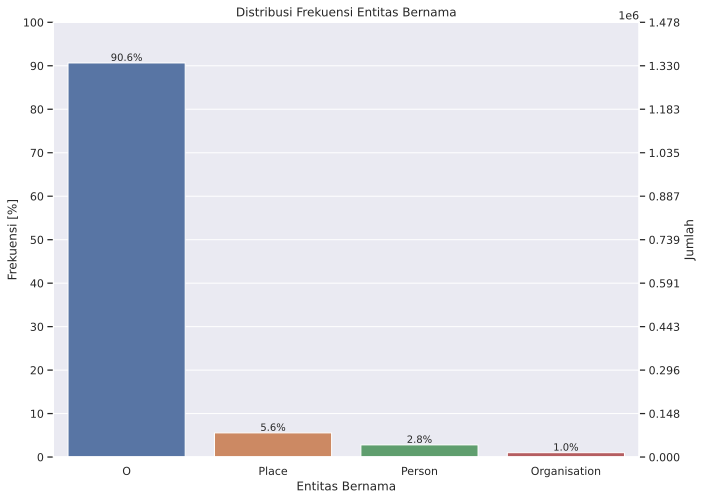

In [17]:
ncount = len(dataset)

plt.figure(figsize=(10.5, 8))
ax = sns.countplot(x = "entitas bernama", data = dataset)
plt.title('Distribusi Frekuensi Entitas Bernama')
plt.xlabel('Entitas Bernama')

# Buat twin axis
ax2 = ax.twinx()

# Tukar sehingga count axis di kanan, frequency di kiri
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Tukar juga label
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax.set_ylabel('Jumlah')
ax2.set_ylabel('Frekuensi [%]')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha = 'center', va = 'bottom') # atur alignment teks

# Gunakan LinearLocator untuk memastikan jumlah tick yang benar
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Perbaiki rentang frekuensi menjadi 0-100
ax2.set_ylim(0, 100)
ax.set_ylim(0, ncount)

# Gunakan MultipleLocator untuk memastikan spaci antar-tick yaitu 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Atur sehingga grid pada ax2 off, supaya gridlines tidak ditampilkan
# pada bagian atas bar
ax2.grid(None)

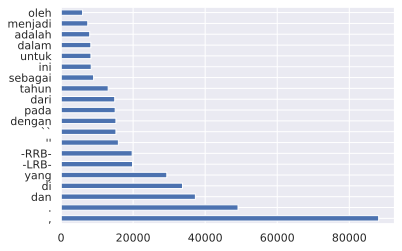

In [18]:
# Visualisasi data 20 token yang paling banyak muncul
dataset['token'].value_counts()[:20].plot(kind='barh')

## **3. Text Preprocessing** ##

*   Expand Contraction





In [19]:
dataset_prep = pd.DataFrame(list_kalimat, columns=['token', 'entitas bernama', 'kalimat'])

In [20]:
#Memperbaiki format penulisan pada kolom token
# re.sub = setiap string yang sesuai dengan pola akan digantikan dengan string yang kita inginkan.
# re.search = searches for that pattern within the string.
import re
def perbaikan_format_tanda_baca(dataset_prep):    
    for i in dataset_prep.index:
        token = re.sub('([.,!?()])', r'\1 ', dataset_prep.at[i, 'token'])
        dataset_prep.at[i, 'token'] = re.sub('\s{2,}', ' ', token)
    return dataset_prep
perbaikan_format_tanda_baca(dataset_prep)

,token,entitas bernama,kalimat
0,Ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,Presiden,O,1
4,ketiga,O,1
...,...,...,...
1478263,di,O,48957
1478264,kalangan,O,48957
1478265,pelajar,O,48957
1478266,Muhammadiyah,Organisation,48957




* Case Folding



In [21]:
dataset_prep['token'] = dataset_prep['token'].str.lower()

In [22]:
dataset_prep.sample(10)

,token,entitas bernama,kalimat
63242,atau,O,2011
401476,giving,O,13245
761703,kerja,O,24922
1162899,",",O,38379
307786,tidak,O,10177
72535,menjadi,O,2335
868965,adalah,O,28610
434468,1,O,14261
1181020,di,O,38974
1034832,3-1,O,34096


## **4.Feature Extraction**

In [23]:

class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                        
                                                           s["entitas bernama"].values.tolist())]
        self.grouped = self.data.groupby("kalimat").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [24]:
getter = getsentence(dataset_prep)

In [25]:
sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])

[('oleh', 'O'), ('dunia', 'O'), ('barat', 'O'), ('ia', 'O'), ('dianggap', 'O'), ('sebagai', 'O'), ('orang', 'O'), ('yang', 'O'), ('sangat', 'O'), ('berpengaruh', 'O'), ('di', 'O'), ('mesir', 'Place'), ('dan', 'O'), ('di', 'O'), ('timur', 'O'), ('tengah', 'O'), ('dalam', 'O'), ('sejarah', 'O'), ('modern', 'O'), ('. ', 'O')]


In [26]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),

        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
      
        })
    else:
        features['EOS'] = True

    return features

In [27]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token,label in sent]

In [28]:
#Membagi data dengan rasio (80:20)
from sklearn.model_selection import train_test_split

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## **5.Modeling and Evaluation**

In [29]:
!pip install python-crfsuite

     |████████████████████████████████| 743 kB 5.2 MB/s 


In [30]:
import pycrfsuite

In [31]:
trainer = pycrfsuite.Trainer(verbose = True)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [32]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [33]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [34]:
trainer.train('indonesian-ner.crfsuite')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 280026
Seconds required: 2.170

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 632558.224652
Feature norm: 1.000000
Error norm: 573953.137334
Active features: 130842
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 1.597

***** Iteration #2 *****
Loss: 469545.803566
Feature norm: 1.811433
Error norm: 101551.693743
Active features: 96266
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.846

***** Iteration #3 *****
Loss: 459878.456797
Feature norm: 1.732442
Error norm: 72404.280360
Active features: 99492
Line search trials: 1
Line search step: 1.000000
Seconds requi

In [35]:
trainer.logparser.last_iteration

{'active_features': 27073,
 'error_norm': 454.471799,
 'feature_norm': 320.927342,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 97856.827371,
 'num': 100,
 'scores': {},
 'time': 0.772}

In [36]:
tagger = pycrfsuite.Tagger()
tagger.open('./indonesian-ner.crfsuite')

In [37]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from itertools import chain

def ner_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_)
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset
    ), accuracy_score(y_true_combined, y_pred_combined)

In [38]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [39]:
report, accuracy = ner_report(y_test, y_pred)

In [40]:
print(report)

              precision    recall  f1-score   support

           O       0.98      0.99      0.98    268429
Organisation       0.83      0.75      0.79      2959
      Person       0.85      0.64      0.73      8319
       Place       0.90      0.82      0.86     16530

   micro avg       0.97      0.97      0.97    296237
   macro avg       0.89      0.80      0.84    296237
weighted avg       0.97      0.97      0.97    296237
 samples avg       0.97      0.97      0.97    296237



In [41]:
print(accuracy)

0.9686804821814966
